In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def f(x):
  return 3*x**2 - 4*x + 5

In [3]:
f(3.0)

20.0

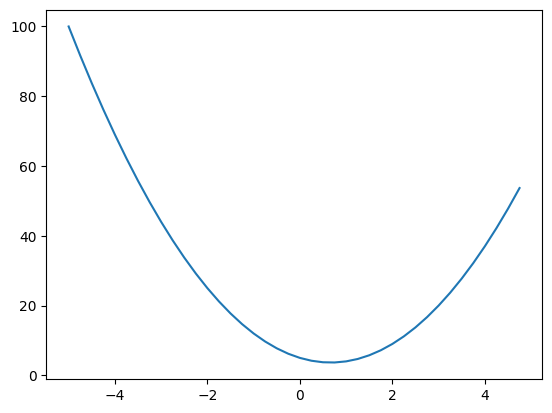

In [4]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)
plt.plot(xs, ys)

In [5]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

In [6]:
# les get more complex
a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [7]:
h = 0.0001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)


d1 4.0
d2 4.0001
slope 0.9999999999976694


In [8]:
import math  # Para funções matemáticas como exp, log, tanh
from typing import List, Union

class Value:
    """
    Representa um valor escalar que participa de um grafo computacional
    para permitir a diferenciação automática (autograd).

    Attributes:
        data (float): The data for the Value node.
        _children (Tuple): The children of the current node.
    """
    
    def __init__(self, data: float, _children: tuple = (), _op: str = '', label: str = ''):
        """
        Inicializa um objeto Value.

        Args:
            data (float): O valor numérico escalar.
            _children (tuple, optional): Uma tupla de objetos Value que são os "filhos"
                                         (operandos) que geraram este Value. Default é ().
            _op (str, optional): A operação que gerou este Value (ex: '+', '*'). Default é ''.
            label (str, optional): Um rótulo opcional para este Value, útil para depuração. Default é ''.
        """
        self.data = data

        # The partial gradient of the last node with respect to this
        # node. This is also termed as the global gradient.
        # Gradient 0.0 means that there is no effect of the change
        # of the last node with respect to this node. On
        # initialization it is assumed that all the variables have no
        # effect on the entire architecture.

        self.grad = 0.0  # Gradiente da saída final da expressão em relação a este Value.]
        
        # The function that derives the gradient of the children nodes
        # of the current node. It is easier this way, because each node
        # is built from children nodes and an operation. Upon back-propagation
        # the current node can easily fill in the gradients of the children.
        # Note: The global gradient is the multiplication of the local gradient
        # and the flowing gradient from the parent.
        # Atributos internos para o backpropagation e construção do grafo:
        self._backward = lambda: None  # Função que propaga o gradiente para os filhos.]
                                      # Será sobrescrita por cada operação.
        
        # Define the children of this node.
        self._prev = set(_children)   # Conjunto dos nós filhos (operandos).]
        self._op = _op                # Operação que criou este nó.]
        self.label = label            # Rótulo para identificação.]

    def custom_addition(self, other: Union["Value", float]) -> "Value":
        """
        The addition operation for the Value class.
        Args:
            other (Union["Value", float]): The other value to add to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = x + y
            >>> z.data
            5
        """
        # If the other value is not a Value, then we need to wrap it.
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value node that will be the output of the addition.
        out = Value(data=self.data + other.data, _children=(self, other))
        def _backward():
            # Local gradient:
            # x = a + b
            # dx/da = 1
            # dx/db = 1
            # Global gradient with chain rule:
            # dy/da = dy/dx . dx/da = dy/dx . 1
            # dy/db = dy/dx . dx/db = dy/dx . 1
            self.grad += out.grad * 1.0
            other.grad += out.grad * 1.0
        # Set the backward function on the output node.
        out._backward = _backward
        return out
    def custom_reverse_addition(self, other):
        """
        Reverse addition operation for the Value class.
        Args:
            other (float): The other value to add to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = y + x
            >>> z.data
            5
        """
        # This is the same as adding. We can reuse the __add__ method.
        return self + other
    
    def custom_multiplication(self, other: Union["Value", float]) -> "Value":
        """
        The multiplication operation for the Value class.
        Args:
            other (float): The other value to multiply to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = x * y
            >>> z.data
            6
        """
        # If the other value is not a Value, then we need to wrap it.
        other = other if isinstance(other, Value) else Value(other)
        # Create a new Value node that will be the output of
        # the multiplication.
        out = Value(data=self.data * other.data, _children=(self, other))
        def _backward():
            # Local gradient:
            # x = a * b
            # dx/da = b
            # dx/db = a
            # Global gradient with chain rule:
            # dy/da = dy/dx . dx/da = dy/dx . b
            # dy/db = dy/dx . dx/db = dy/dx . a
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        # Set the backward function on the output node.
        out._backward = _backward
        return out

    def custom_reverse_multiplication(self, other):
        """
        Reverse multiplication operation for the Value class.
        Args:
            other (float): The other value to multiply to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = y * x
            >>> z.data
            6
        """
        # This is the same as multiplying. We can reuse the __mul__ method.
        return self * other
    
    def custom_power(self, other):
        """
        The power operation for the Value class.
        Args:
            other (float): The other value to raise this one to.
        Usage:
            >>> x = Value(2)
            >>> z = x ** 2.0
            >>> z.data
            4
        """
        assert isinstance(
            other, (int, float)
        ), "only supporting int/float powers for now"
        # Create a new Value node that will be the output of the power.
        out = Value(data=self.data ** other, _children=(self,))
        def _backward():
            # Local gradient:
            # x = a ** b
            # dx/da = b * a ** (b - 1)
            # Global gradient:
            # dy/da = dy/dx . dx/da = dy/dx . b * a ** (b - 1)
            self.grad += out.grad * (other * self.data ** (other - 1))
        # Set the backward function on the output node.
        out._backward = _backward
        return out
    
    def custom_negation(self):
        """
        Negation operation for the Value class.
        Usage:
            >>> x = Value(2)
            >>> z = -x
            >>> z.data
            -2
        """
        # This is the same as multiplying by -1. We can reuse the
        # __mul__ method.
        return self * -1
    
    def custom_subtraction(self, other):
        """
        Subtraction operation for the Value class.
        Args:
            other (float): The other value to subtract to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = x - y
            >>> z.data
            -1
        """
        # This is the same as adding the negative of the other value.
        # We can reuse the __add__ and the __neg__ methods.
        return self + (-other)
    def custom_reverse_subtraction(self, other):
        """
        Reverse subtraction operation for the Value class.
        Args:
            other (float): The other value to subtract to this one.
        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = y - x
            >>> z.data
            1
        """
        # This is the same as subtracting. We can reuse the __sub__ method.
        return other + (-self)
    
    def custom_division(self, other):
        """
        Division operation for the Value class.
        Args:
            other (float): The other value to divide to this one.
        Usage:
            >>> x = Value(10)
            >>> y = Value(5)
            >>> z = x / y
            >>> z.data
            2
        """
        # Use the __pow__ method to implement division.
        return self * other ** -1
    def custom_reverse_division(self, other):
        """
        Reverse division operation for the Value class.
        Args:
            other (float): The other value to divide to this one.
        Usage:
            >>> x = Value(10)
            >>> y = Value(5)
            >>> z = y / x
            >>> z.data
            0.5
        """
        # Use the __pow__ method to implement division.
        return other * self ** -1
    

    # Value.__truediv__ = custom_division
    # Value.__rtruediv__ = custom_reverse_division
    # Value.__sub__ = custom_subtraction
    # Value.__rsub__ = custom_reverse_subtraction
    # Value.__neg__ = custom_negation
    # Value.__pow__ = custom_power
    # Value.__mul__ = custom_multiplication
    # Value.__rmul__ = custom_reverse_multiplication
    # Value.__add__ = custom_addition
    # Value.__radd__ = custom_reverse_addition

    def __repr__(self) -> str:
        """
        Representação em string do objeto Value, mostrando data, rótulo e gradiente.
        """
        return f"Value(data={self.data:.4f}, label='{self.label}', grad={self.grad:.4f})"

    def _ensure_value(self, other) -> 'Value':
        """
        Garante que o 'other' operando seja também um objeto Value.
        Se for um número (int ou float), ele é convertido para Value.
        """
        return other if isinstance(other, Value) else Value(other)

    # --- Operações Aritméticas e Métodos Especiais ---

    def __add__(self, other) -> 'Value':
        """
        Implementa a adição: self + other.
        """
        other = self._ensure_value(other) # Garante que 'other' seja um Value]
        out = Value(self.data + other.data, (self, other), '+')
        
        def _backward():
            # Derivada da soma: d(out)/d(self) = 1, d(out)/d(other) = 1
            # Aplicando a regra da cadeia: dL/d(self) = dL/d(out) * d(out)/d(self)
            self.grad += 1.0 * out.grad  #]
            other.grad += 1.0 * out.grad #]
        out._backward = _backward
        
        return out

    def __mul__(self, other) -> 'Value':
        """
        Implementa a multiplicação: self * other.
        """
        other = self._ensure_value(other) # Garante que 'other' seja um Value]
        out = Value(self.data * other.data, (self, other), '*')
        
        def _backward():
            # Derivada do produto: d(out)/d(self) = other.data, d(out)/d(other) = self.data
            self.grad += other.data * out.grad  #]
            other.grad += self.data * out.grad #]
        out._backward = _backward
          
        return out

    def __pow__(self, other: float) -> 'Value':
        """
        Implementa a potenciação: self ** other (onde 'other' é um escalar int ou float).
        """
        assert isinstance(other, (int, float)), "Apenas potências escalares (int/float) são suportadas por enquanto."
        out = Value(self.data ** other, (self,), f'**{other}')

        def _backward():
            # Derivada de x^n = n * x^(n-1)
            self.grad += (other * (self.data ** (other - 1))) * out.grad #]
        out._backward = _backward

        return out
        
    def __neg__(self) -> 'Value': # -self
        """
        Implementa a negação: -self. É o mesmo que self * -1.
        """
        return self * -1 #]

    def __sub__(self, other) -> 'Value': # self - other
        """
        Implementa a subtração: self - other. É o mesmo que self + (-other).
        """
        return self + (-other) #]

    def __truediv__(self, other) -> 'Value': # self / other
        """
        Implementa a divisão: self / other. É o mesmo que self * (other ** -1).
        """
        return self * (self._ensure_value(other) ** -1) #]

    # Métodos refletidos para operações onde Value não é o primeiro operando (ex: 2 + a)
    def __radd__(self, other) -> 'Value': # other + self
        return self + other #]

    def __rsub__(self, other) -> 'Value': # other - self
        return self._ensure_value(other) + (-self)

    def __rmul__(self, other) -> 'Value': # other * self
        return self * other #]

    def __rtruediv__(self, other) -> 'Value': # other / self
        return self._ensure_value(other) * (self ** -1)

    # --- Funções de Ativação e Outras Funções Matemáticas ---

    def relu(self):
        """
        The ReLU activation function.
        Usage:
            >>> x = Value(-2)
            >>> y = x.relu()
            >>> y.data
            0
        """
        out = Value(data=0 if self.data < 0 else self.data, _children=(self,))
        def _backward():
            # Local gradient:
            # x = relu(a)
            # dx/da = 0 if a < 0 else 1
            # Global gradient:
            # dy/da = dy/dx . dx/da = dy/dx . (0 if a < 0 else 1)
            self.grad += out.grad * (out.data > 0)
        # Set the backward function on the output node.
        out._backward = _backward
        return out
    def tanh(self) -> 'Value':
        """
        Implementa a função de ativação tangente hiperbólica.
        tanh(x) = (e^(2x) - 1) / (e^(2x) + 1)
        """
        x = self.data
        t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1) #]
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            # Derivada de tanh(x) = 1 - tanh(x)^2 = 1 - t^2
            self.grad += (1 - t**2) * out.grad #]
        out._backward = _backward
        
        return out

    def exp(self) -> 'Value':
        """
        Implementa a função exponencial: e ** self.data
        """
        x = self.data
        out = Value(math.exp(x), (self,), 'exp') #]
        
        def _backward():
            # Derivada de e^x = e^x
            self.grad += out.data * out.grad # out.data é e^x]
        out._backward = _backward
        return out

    def log(self, base: float = math.e) -> 'Value':
        """
        Implementa a função logarítmica (log natural por padrão).
        """
        x = self.data
        if x <= 0:
            raise ValueError("Logaritmo indefinido ou complexo para data <= 0.")
        
        # Logaritmo na base desejada
        log_val = math.log(x, base)
        out = Value(log_val, (self,), f'log_base{base:.2f}')
        
        def _backward():
            # Derivada de log_b(x) = 1 / (x * ln(b))
            # Para log natural (ln(x), base=e), a derivada é 1/x.
            self.grad += (1 / (x * math.log(base))) * out.grad
        out._backward = _backward
        return out
    
    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')
        
        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        
        return out
    
    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')
        
        def _backward():
            self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
        out._backward = _backward
        
        return out

    # --- Backpropagation ---
    def backward(self):
        """
        Realiza o backpropagation a partir deste Value (geralmente o nó de perda).
        Calcula os gradientes para todos os Values no grafo que levaram a este.

        Usage:
            >>> x = Value(2)
            >>> y = Value(3)
            >>> z = x * y
            >>> z.backward()
            >>> x.grad
            3
            >>> y.grad
            2
        """
        # Build an empty list which will hold the
        # topologically sorted graph
        topo = []
        # Build a set of all the visited nodes
        visited = set()
        # A closure to help build the topologically sorted graph
        def build_topo(node: "Value"):
            if node not in visited:
                # If node is not visited add the node to the
                # visited set.
                visited.add(node)
                # Iterate over the children of the node that
                # is being visited
                for child in node._prev:
                    # Apply recursion to build the topologically sorted
                    # graph of the children
                    build_topo(child)
                
                # Only append node to the topologically sorted list
                # if all its children are visited.
                topo.append(node)
        # Call the `build_topo` method on self
        build_topo(self)
        # Go one node at a time and apply the chain rule
        # to get its gradient
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()
    

In [9]:
# Now create an expression that uses a lot of
# primitive operations
a = Value(2.0, label="a")
b = Value(3.0, label="b")
c = a+b
d = 4.0
e = c**d
f = Value(6.0, label="f")
g = e/f

c.label = "c"
e.label = "e"
f.label = "f"
g.label = "g"

print("BEFORE backward")
for element in [a, b, c, d, e, f, g]:
    print(element)
# Backward on the final node will backprop
# the gradients through the entire DAG
g.backward()
print("AFTER backward")
for element in [a, b, c, d, e, f, g]:
    print(element)

BEFORE backward
Value(data=2.0000, label='a', grad=0.0000)
Value(data=3.0000, label='b', grad=0.0000)
Value(data=5.0000, label='c', grad=0.0000)
4.0
Value(data=625.0000, label='e', grad=0.0000)
Value(data=6.0000, label='f', grad=0.0000)
Value(data=104.1667, label='g', grad=0.0000)
AFTER backward
Value(data=2.0000, label='a', grad=83.3333)
Value(data=3.0000, label='b', grad=83.3333)
Value(data=5.0000, label='c', grad=83.3333)
4.0
Value(data=625.0000, label='e', grad=0.1667)
Value(data=6.0000, label='f', grad=-17.3611)
Value(data=104.1667, label='g', grad=1.0000)


In [10]:
# 1. Criando Values e operações básicas
a = Value(2.0, label='a')
b = Value(-3.0, label='b')
c = Value(10.0, label='c')

# Adição
d = a + b; d.label = 'd'  # d.data = -1.0
print(f"{a} + {b} = {d}")

# Multiplicação
e = d * c; e.label = 'e'  # e.data = -10.0
print(f"{d} * {c} = {e}")

# Operação com escalar (graças ao _ensure_value e __rmul__)
f = 2 * e; f.label = 'f' # f.data = -20.0
print(f"2 * {e} = {f}")

# Negação
g = -f; g.label = 'g' # g.data = 20.0
print(f"-{f} = {g}")

# Potenciação
h_val = Value(3.0, label='h_val')
i = h_val**3; i.label = 'i' # i.data = 27.0
print(f"{h_val} ** 3 = {i}")

# Subtração
j = i - Value(7.0, label='sete'); j.label = 'j' # j.data = 20.0
print(f"{i} - Value(7.0) = {j}")

# Divisão
k_val = Value(4.0, label='k_val')
m = j / k_val; m.label = 'm' # m.data = 5.0
print(f"{j} / {k_val} = {m}")

# Tanh
n = m.tanh(); n.label = 'n' # n.data = tanh(5.0) ~ 0.9999
print(f"tanh({m}) = {n}")

# Exp e Log
p_val = Value(1.0, label='p_val')
q = p_val.exp(); q.label = 'q' # q.data = e^1 ~ 2.718
r = q.log(); r.label = 'r'     # r.data = ln(e^1) = 1.0
print(f"exp({p_val}) = {q}")
print(f"log({q}) = {r}")

print("\n--- Exemplo de Backpropagation ---")
# Expressão do vídeo: L = d * f_video (usando nomes diferentes para evitar conflito com 'f' acima)
# Onde d = e_video + c_video
# E   e_video = a_video * b_video

a_video = Value(2.0, label='a_video')
b_video = Value(-3.0, label='b_video')
c_video = Value(10.0, label='c_video')
f_video = Value(-2.0, label='f_video')

e_video = a_video * b_video
e_video.label = 'e_video'

d_video = e_video + c_video
d_video.label = 'd_video'

L = d_video * f_video
L.label = 'L'

print(f"Expressão: L = ({a_video.label}*{b_video.label} + {c_video.label}) * {f_video.label}")
print(f"Valor final de L: {L}")

# # Realizando o backpropagation
L.backward()

# print("\nGradientes calculados:")
# print(L)
# print(d_video)
# print(f_video)
# print(e_video)
# print(c_video)
# print(a_video)
# print(b_video)

# # Verificando os gradientes (como no vídeo)
# # dL/dL = 1.0
# # L = d_video * f_video => dL/d(d_video) = f_video.data = -2.0
# #                        => dL/d(f_video) = d_video.data = 4.0
# # d_video = e_video + c_video => d(d_video)/d(e_video) = 1.0
# #                           => d(d_video)/d(c_video) = 1.0
# # Por regra da cadeia: dL/d(e_video) = dL/d(d_video) * d(d_video)/d(e_video) = -2.0 * 1.0 = -2.0
# #                    dL/d(c_video) = dL/d(d_video) * d(d_video)/d(c_video) = -2.0 * 1.0 = -2.0
# # e_video = a_video * b_video => d(e_video)/d(a_video) = b_video.data = -3.0
# #                           => d(e_video)/d(b_video) = a_video.data = 2.0
# # Por regra da cadeia: dL/d(a_video) = dL/d(e_video) * d(e_video)/d(a_video) = -2.0 * -3.0 = 6.0
# #                    dL/d(b_video) = dL/d(e_video) * d(e_video)/d(b_video) = -2.0 * 2.0 = -4.0

# assert abs(L.grad - 1.0) < 1e-5
# assert abs(d_video.grad - (-2.0)) < 1e-5
# assert abs(f_video.grad - 4.0) < 1e-5
# assert abs(e_video.grad - (-2.0)) < 1e-5
# assert abs(c_video.grad - (-2.0)) < 1e-5
# assert abs(a_video.grad - 6.0) < 1e-5
# assert abs(b_video.grad - (-4.0)) < 1e-5
# print("\nTodos os gradientes verificados com sucesso!")

Value(data=2.0000, label='a', grad=0.0000) + Value(data=-3.0000, label='b', grad=0.0000) = Value(data=-1.0000, label='d', grad=0.0000)
Value(data=-1.0000, label='d', grad=0.0000) * Value(data=10.0000, label='c', grad=0.0000) = Value(data=-10.0000, label='e', grad=0.0000)
2 * Value(data=-10.0000, label='e', grad=0.0000) = Value(data=-20.0000, label='f', grad=0.0000)
-Value(data=-20.0000, label='f', grad=0.0000) = Value(data=20.0000, label='g', grad=0.0000)
Value(data=3.0000, label='h_val', grad=0.0000) ** 3 = Value(data=27.0000, label='i', grad=0.0000)
Value(data=27.0000, label='i', grad=0.0000) - Value(7.0) = Value(data=20.0000, label='j', grad=0.0000)
Value(data=20.0000, label='j', grad=0.0000) / Value(data=4.0000, label='k_val', grad=0.0000) = Value(data=5.0000, label='m', grad=0.0000)
tanh(Value(data=5.0000, label='m', grad=0.0000)) = Value(data=0.9999, label='n', grad=0.0000)
exp(Value(data=1.0000, label='p_val', grad=0.0000)) = Value(data=2.7183, label='q', grad=0.0000)
log(Value(

In [11]:
class Module(object):
    """
    the parent class for all neutal network
    """

    def zero_grad(self):
        """
        This is used to zero out all the gradients of the parameters.
        """
        for p in self.parameters():
            p.grad = 0


    def parameters(self):
        """
        This function is built to be overwritten. This would eventually get us the parameters of the neurons, layers, and the mlp.
        """
        return []

In [12]:
import random
from typing import List

class Neuron(Module):
    """
    A single neuron.
    Parameters:
        number_inputs (int): number of inputs
        is_nonlinear (bool): whether to apply ReLU nonlinearity
        name (int): the index of neuron
    """
    def __init__(self, number_inputs: int, name, is_nonlinear: bool = True):
        # Create weights for the neuron. The weights are initialized
        # from a random uniform distribution.
        self.weights = [Value(data=random.uniform(-1, 1)) for _ in range(number_inputs)]
        # Create bias for the neuron.
        self.bias = Value(data=0.0)
        self.is_nonlinear = is_nonlinear
        self.name = name

    def __call__(self, x: List["Value"]) -> "Value":
        # Compute the dot product of the input and the weights. Add the
        # bias to the dot product.
        act = sum(
            ((wi * xi) for wi, xi in zip(self.weights, x)),
            self.bias
        )
        # If activation is mentioned, apply ReLU to it.
        return act.relu() if self.is_nonlinear else act

    def parameters(self):
        # Get the parameters of the neuron. The parameters of a neuron
        # is its weights and bias.
        return self.weights + [self.bias]

    def __repr__(self):
        # Print a better representation of the neuron.
        return f"Neuron {self.name}(Number={len(self.weights)}, Non-Linearity={'ReLU' if self.is_nonlinear else 'None'})"
    
x = [2.0, 3.0]
neuron = Neuron(number_inputs=2, name=1)
print(neuron)
out = neuron(x)
print(f"Output => {out}")

Neuron 1(Number=2, Non-Linearity=ReLU)
Output => Value(data=0.0000, label='', grad=0.0000)


In [13]:
class Layer(Module):
    """
    A layer of neurons.
    Parameters:
        number_inputs (int): number of inputs
        number_outputs (int): number of outputs
        name (int): index of the layer
    """
    def __init__(self, number_inputs: int, number_outputs: int, name: int, **kwargs):
        # A layer is a list of neurons.
        self.neurons = [
            Neuron(number_inputs=number_inputs, name=idx, **kwargs) for idx in range(number_outputs)
        ]
        self.name = name
        self.number_outputs = number_outputs
    def __call__(self, x: List["Value"]) -> Union[List["Value"], "Value"]:
        # Iterate over all the neurons and compute the output of each.
        out = [n(x) for n in self.neurons]
        return out if self.number_outputs != 1 else out[0]
    def parameters(self):
        # The parameters of a layer is the parameters of all the neurons.
        return [p for n in self.neurons for p in n.parameters()]
    def __repr__(self):
        # Print a better representation of the layer.
        layer_str = "\n".join(f'    - {str(n)}' for n in self.neurons)
        return f"Layer {self.name} \n{layer_str}\n"
    
x = [2.0, 3.0]
layer = Layer(number_inputs=2, number_outputs=3, name=1)
print(layer)
out = layer(x)
print(f"Output => {out}")
print()

x = [2.0, 3.0]
layer = Layer(number_inputs=2, number_outputs=1, name=1)
print(layer)
out = layer(x)
print(f"Output => {out}")

Layer 1 
    - Neuron 0(Number=2, Non-Linearity=ReLU)
    - Neuron 1(Number=2, Non-Linearity=ReLU)
    - Neuron 2(Number=2, Non-Linearity=ReLU)

Output => [Value(data=0.0000, label='', grad=0.0000), Value(data=0.0000, label='', grad=0.0000), Value(data=0.7501, label='', grad=0.0000)]

Layer 1 
    - Neuron 0(Number=2, Non-Linearity=ReLU)

Output => Value(data=3.5106, label='', grad=0.0000)


### Multilayer Perceptron

A Multilayer Perceptron (MLP) is built of a number of Layers.

In [ ]:
class MLP(Module):
    """
    The Multi-Layer Perceptron (MLP) class.
    Parameters:
        number_inputs (int): number of inputs.
        list_number_outputs (List[int]): number of outputs in each layer.
    """
    def __init__(self, number_inputs: int, list_number_outputs: List[int]):
        # Get the number of inputs and all the number of outputs in
        # a single list.
        total_size = [number_inputs] + list_number_outputs
        # Build layers by connecting each layer to the previous one.
        self.layers = [
            # Do not use non linearity in the last layer.
            Layer(
                number_inputs=total_size[i],
                number_outputs=total_size[i + 1],
                name=i,
                is_nonlinear=i != len(list_number_outputs) - 1
            )
            for i in range(len(list_number_outputs))
        ]
    def __call__(self, x: List["Value"]) -> List["Value"]:
        # Iterate over the layers and compute the output of
        # each sequentially.
        for layer in self.layers:
            x = layer(x)
        return x
    def parameters(self):
        # Get the parameters of the MLP
        return [p for layer in self.layers for p in layer.parameters()]

    def __repr__(self):
        # Print a better representation of the MLP.
        mlp_str = "\n".join(f'  - {str(layer)}' for layer in self.layers)
        return f"MLP of \n{mlp_str}"

x = [2.0, 3.0]
mlp = MLP(number_inputs=2, list_number_outputs=[3, 3, 1])
print(mlp)
out = mlp(x)
print(f"Output => {out}")

MLP of 
  - Layer 0 
    - Neuron 0(Number=2, Non-Linearity=ReLU)
    - Neuron 1(Number=2, Non-Linearity=ReLU)
    - Neuron 2(Number=2, Non-Linearity=ReLU)

  - Layer 1 
    - Neuron 0(Number=3, Non-Linearity=ReLU)
    - Neuron 1(Number=3, Non-Linearity=ReLU)
    - Neuron 2(Number=3, Non-Linearity=ReLU)

  - Layer 2 
    - Neuron 0(Number=3, Non-Linearity=None)

Output => Value(data=1.4686, label='', grad=0.0000)


In [28]:
def forward(mlp: "MLP", xs: List[List[float]]) -> List["Value"]:
    """
    The forward function takes the mlp and the inputs. The inputs are forwarded through the mlp, and we obtain the predictions from the mlp.
    """
    # Get the predictions upon forwarding the input data through the mlp
    y_pred = [mlp(x) for x in xs]
    return y_pred

def compute_loss(ys: List[int], y_pred: List["Value"]) -> "Value":
    """
    We have ground truth and predictions. This function computes the loss between the two. We will optimize our mlp to make the loss go to zero.
    """
    # Obtain the L2 distance of the prediction and ground truths
    loss = sum(
        [(ygt - yout)**2 for ygt, yout in zip(ys, y_pred)]
    )
    return loss

def update_mlp(mlp: "MLP"):
    """
    In this function, we update the parameters (weights and biases) of our mlp with the gradient information.
    """
    # Iterate over all the layers of the MLP
    for layer in mlp.layers:
        # Iterate over all the neurons of each layer
        for neuron in layer.neurons:
            # Iterate over all the weights of each neuron
            for weight in neuron.weights:
                # Update the data of the weight with the 
                # gradient information.
                weight.data -= (1e-2 * weight.grad)
            # Update the data of the bias with the 
            # gradient information.
            neuron.bias.data -= (1e-2 * neuron.bias.grad)

### Train the MLP

In this section, we will create a small dataset and try to understand how to model the dataset with our MLP.

In [ ]:
# Build a dataset

xs = np.array([
    [0.5, 0.5, 0.70],
    [0.4, -0.1, 0.5],
    [-0.2, -0.75, 1.0],
    [-0.2, -0.75, 1.0],
])

ys = np.array([0.0, 1.0, 0.0, 0.0])

# Build an MLP
mlp = MLP(number_inputs=3, list_number_outputs=[3, 3, 1])



# Define the epochs for which we want to run the training process.
epochs = 500
# Define a loss list to help log the loss.
loss_list = []
# Iterate each epoch and train the model.
for idx in range(epochs):
    # Step 1: Forward the inputs to the mlp and get the predictions
    y_pred = forward(mlp, xs)
    # Step 2: Compute Loss between the predictions and the ground truths
    loss = compute_loss(ys, y_pred)
    # Step 3: Ground the gradients. These accumulate which is not desired.
    mlp.zero_grad()
    # Step 4: Backpropagate the gradients through the entire architecture
    loss.backward()
    # Step 5: Update the mlp
    update_mlp(mlp)
    # Step 6: Log the loss
    loss_list.append(loss.data)
    print(f"Epoch {idx}: Loss {loss.data: 0.2f}")

Epoch 0: Loss  1.43
Epoch 1: Loss  1.36
Epoch 2: Loss  1.31
Epoch 3: Loss  1.27
Epoch 4: Loss  1.24
Epoch 5: Loss  1.21
Epoch 6: Loss  1.19
Epoch 7: Loss  1.17
Epoch 8: Loss  1.15
Epoch 9: Loss  1.13
Epoch 10: Loss  1.11
Epoch 11: Loss  1.10
Epoch 12: Loss  1.08
Epoch 13: Loss  1.07
Epoch 14: Loss  1.06
Epoch 15: Loss  1.04
Epoch 16: Loss  1.03
Epoch 17: Loss  1.02
Epoch 18: Loss  1.01
Epoch 19: Loss  1.00
Epoch 20: Loss  0.99
Epoch 21: Loss  0.98
Epoch 22: Loss  0.98
Epoch 23: Loss  0.97
Epoch 24: Loss  0.96
Epoch 25: Loss  0.95
Epoch 26: Loss  0.95
Epoch 27: Loss  0.94
Epoch 28: Loss  0.93
Epoch 29: Loss  0.93
Epoch 30: Loss  0.92
Epoch 31: Loss  0.92
Epoch 32: Loss  0.91
Epoch 33: Loss  0.90
Epoch 34: Loss  0.90
Epoch 35: Loss  0.90
Epoch 36: Loss  0.89
Epoch 37: Loss  0.89
Epoch 38: Loss  0.88
Epoch 39: Loss  0.88
Epoch 40: Loss  0.87
Epoch 41: Loss  0.87
Epoch 42: Loss  0.87
Epoch 43: Loss  0.86
Epoch 44: Loss  0.86
Epoch 45: Loss  0.85
Epoch 46: Loss  0.85
Epoch 47: Loss  0.85
Ep

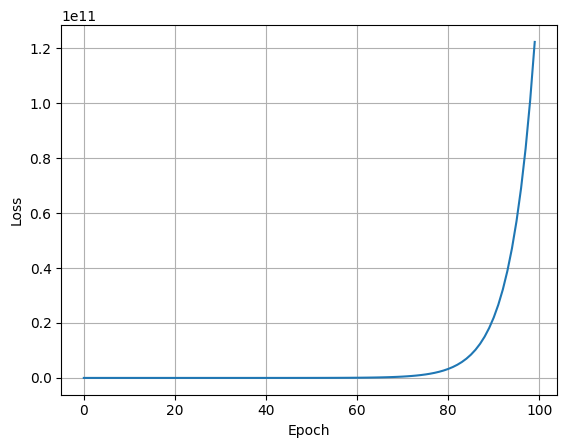

In [25]:
# Plot the loss
plt.plot(loss_list)
plt.grid()
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.show()

In [18]:
# Inference
pred = mlp(xs[0])
ygt = ys[0]

print(f"Prediction => {pred.data: 0.2f}")
print(f"Ground Truth => {ygt: 0.2f}")

Prediction =>  0.00
Ground Truth =>  0.00


---

In [23]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

# Carregar o dataset
iris = load_iris()
X, y = iris.data, iris.target

# Pré-processamento: Padronizar as features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividir em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

# Se seu MLP espera y como one-hot encoding para multiclasse:
# (Assumindo que n_classes = 3 para o Iris dataset)
# y_train_one_hot = np.eye(len(np.unique(y_train)))[y_train]
# y_test_one_hot = np.eye(len(np.unique(y_test)))[y_test]

print(f"Formato de X_train: {X_train.shape}")
print(f"Formato de y_train: {y_train.shape}")
# print(f"Formato de y_train_one_hot: {y_train_one_hot.shape}") # Se usar one-hot

xs = X_train
ys = y_train

Formato de X_train: (105, 4)
Formato de y_train: (105,)


In [20]:
# Build a dataset

xs = np.array([
    [0.5, 0.5, 0.70],
    [0.4, -0.1, 0.5],
    [-0.2, -0.75, 1.0],
    [-0.2, -0.75, 1.0],
])

ys = np.array([0.0, 1.0, 0.0, 0.0])

In [21]:
number_inputs = xs.shape[1]

In [24]:


# Build an MLP
mlp = MLP(number_inputs=3, list_number_outputs=[3, 3, 1])



# Define the epochs for which we want to run the training process.
epochs = 100
# Define a loss list to help log the loss.
loss_list = []
# Iterate each epoch and train the model.
for idx in range(epochs):
    # Step 1: Forward the inputs to the mlp and get the predictions
    ypred = forward(mlp, xs)
    # Step 2: Compute Loss between the predictions and the ground truths
    loss = compute_loss(ys, ypred)
    # Step 3: Ground the gradients. These accumulate which is not desired.
    mlp.zero_grad()
    # Step 4: Backpropagate the gradients through the entire architecture
    loss.backward()
    # Step 5: Update the mlp
    update_mlp(mlp)
    # Step 6: Log the loss
    loss_list.append(loss.data)
    print(f"Epoch {idx}: Loss {loss.data: 0.2f}")

Epoch 0: Loss  152.47
Epoch 1: Loss  363.51
Epoch 2: Loss  1188.83
Epoch 3: Loss  1449.72
Epoch 4: Loss  1739.46
Epoch 5: Loss  2090.04
Epoch 6: Loss  2514.25
Epoch 7: Loss  3027.55
Epoch 8: Loss  3648.63
Epoch 9: Loss  4400.14
Epoch 10: Loss  5309.47
Epoch 11: Loss  6409.76
Epoch 12: Loss  7741.11
Epoch 13: Loss  9352.05
Epoch 14: Loss  11301.28
Epoch 15: Loss  13659.85
Epoch 16: Loss  16513.71
Epoch 17: Loss  19966.89
Epoch 18: Loss  24145.24
Epoch 19: Loss  29201.04
Epoch 20: Loss  35318.56
Epoch 21: Loss  42720.76
Epoch 22: Loss  51677.42
Epoch 23: Loss  62514.98
Epoch 24: Loss  75628.42
Epoch 25: Loss  91495.69
Epoch 26: Loss  110695.08
Epoch 27: Loss  133926.35
Epoch 28: Loss  162036.18
Epoch 29: Loss  196049.08
Epoch 30: Loss  237204.69
Epoch 31: Loss  287002.97
Epoch 32: Loss  347258.90
Epoch 33: Loss  420168.57
Epoch 34: Loss  508389.27
Epoch 35: Loss  615136.31
Epoch 36: Loss  744300.24
Epoch 37: Loss  900588.59
Epoch 38: Loss  1089697.49
Epoch 39: Loss  1318519.27
Epoch 40: 

----

In [ ]:
d_video._backward()

f_video.grad, d_video.grad, e_video.grad, a_video.grad

(0.0, 0.0, 0.0, 0.0)

In [ ]:
e_video

Value(data=-6.0000, label='e_video', grad=0.0000)

In [ ]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot


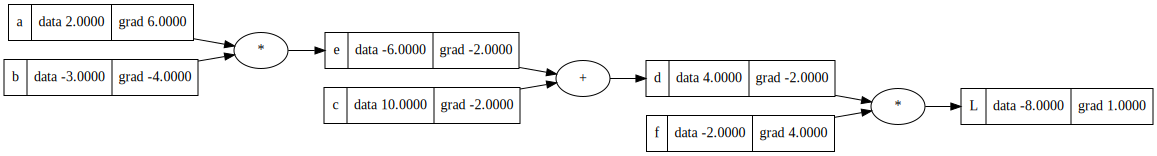

In [ ]:
draw_dot(L)

In [ ]:
a.data += 0.01 * a.grad
b.data += 0.01 * b.grad
c.data += 0.01 * c.grad
f.data += 0.01 * f.grad

e = a * b
d = e + c
L = d * f

print(L.data)


-7.286496


In [ ]:
def lol():
  
  h = 0.001
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data
  
  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  b.data += h
  c = Value(10.0, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data
  
  print((L2 - L1)/h)
  
lol()

-3.9999999999995595


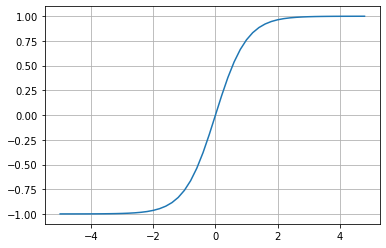

In [ ]:
plt.plot(np.arange(-5,5,0.2), np.tanh(np.arange(-5,5,0.2))); plt.grid();

In [ ]:
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

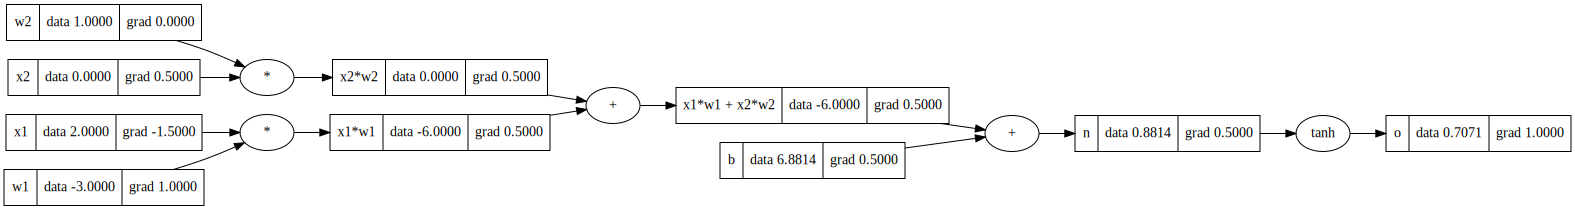

In [ ]:
draw_dot(o)

In [ ]:
o.backward()

In [ ]:
topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
    for child in v._prev:
      build_topo(child)
    topo.append(v)
build_topo(o)
topo

[Value(data=6.881373587019543),
 Value(data=2.0),
 Value(data=-3.0),
 Value(data=-6.0),
 Value(data=0.0),
 Value(data=1.0),
 Value(data=0.0),
 Value(data=-6.0),
 Value(data=0.8813735870195432),
 Value(data=0.7071067811865476)]

In [ ]:
o.grad = 1.0

In [ ]:
o._backward()

In [ ]:
n._backward()

In [ ]:
b._backward()

In [ ]:
x1w1x2w2._backward()

In [ ]:
x2w2._backward()
x1w1._backward()

In [ ]:
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

In [ ]:
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

In [ ]:
x1w1.grad = 0.5
x2w2.grad = 0.5

In [ ]:
x1w1x2w2.grad = 0.5
b.grad = 0.5

In [ ]:
n.grad = 0.5

In [ ]:
o.grad = 1.0

In [ ]:
1 - o.data**2

0.4999999999999999

In [ ]:
# o = tanh(n)
# do/dn = 1 - o**2

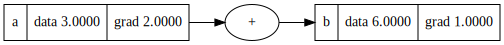

In [ ]:
a = Value(3.0, label='a')
b = a + a   ; b.label = 'b'
b.backward()
draw_dot(b)

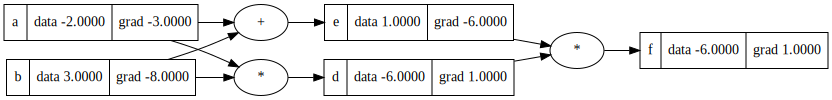

In [ ]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b    ; d.label = 'd'
e = a + b    ; e.label = 'e'
f = d * e    ; f.label = 'f'

f.backward()

draw_dot(f)